### Predicting the Price of Homes in Boston

The data are available to load from Scikit-Learn, and you can read more about it [here](https://scikit-learn.org/stable/datasets/index.html#boston-dataset).

---
##### Columns in the data set:
- `CRIM`: per capita crime rate by town
- `ZN`: proportion of residential land zoned for lots over 25,000 sq.ft.
- `INDUS`: proportion of non-retail business acres per town
- `CHAS`: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- `NX`: nitric oxides concentration (parts per 10 million)
- `RM`: average number of rooms per dwelling
- `AGE`: proportion of owner-occupied units built prior to 1940
- `DIS`: weighted distances to five Boston employment centres
- `RAD`: index of accessibility to radial highways
- `TAX`: full-value property-tax rate per $10,000
- `PTRATIO`: pupil-teacher ratio by town
- `B`: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

- `LSTAT`: percent lower status of the population
- `MEDV`: Median value of owner-occupied homes in $1000’s

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

In [48]:
# Read the CSV file into a DataFrame
df = pd.read_csv('datasets/boston.csv')

# Explore the dataframe
df.head()

,CRIM,ZN,INDUS,CHAS,NX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


#### Understanding the Data - MEDV
MEDV is the *median* value of owner-occupied homes in $1000’s (this is back in the 1970s, mind you). Given that I'll explore summary statistcs about this column which I'll try to predict later on. Following this, I'll take a look at which of the rest of the columns correlates with MEDV.

In [56]:
# Print summary statistics on MEDV
prices = df['MEDV'] * 1000.0

# Minimum price
minimum_price = np.amin(prices)

# Maximum price
maximum_price = np.amax(prices)

# Mean price
mean_price = np.mean(prices)

# Median price
median_price = np.median(prices)

# Standard deviation of prices
std_price = np.std(prices)

# Show the calculated statistics
print "Statistics for Boston housing dataset:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for Boston housing dataset:

Minimum price: $5,000.00
Maximum price: $50,000.00
Mean price: $22,532.81
Median price $21,200.00
Standard deviation of prices: $9,188.01


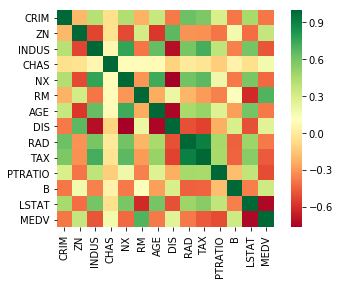

In [57]:
# Plot the correlation between different features in the datatset.
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

#### Single feature prediction
You can see from the heat map above that`MEDV` is more (positively) correlated with `RM` than any other of the features.

As a first exploratory task, I'll build a price prediction model based a single feature, `RM`. The effort here is to establish a working model from which a prediction can be made. Later I'll incorporate all the features and fine tune the model to make a more accurate and robust prediction. Intuitively, you would think the number of rooms in a given house should correlate positively with it's value. To be sure, I'll explore the results of a plot of home prices to number of rooms.

In [58]:
# Create arrays for the feature and target variables
y = df['MEDV'].values
X = df.drop('MEDV', axis=1).values

# Slice an array which contains only the RM column
X_rooms = X[:,5]

# Reshape both y and X_rooms--keep the first dimension and add an additional dimension of size 1 to X_rooms
y = y.reshape(-1,1)
X_rooms = X_rooms.reshape(-1,1)

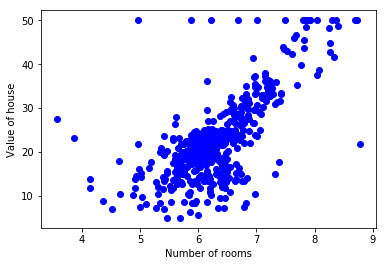

In [59]:
# Plot home price vs number of rooms
plt.scatter(X_rooms, y, color='blue')
plt.ylabel('Value of house')
plt.xlabel('Number of rooms')
plt.show()

#### More Rooms Means Higher Prices
Generally speaking we can see that home prices increase with additional rooms. Just eyeballing the scatter plot one could imagine a a line with a positive slope and a certain y-intercept would probably estimate the correlation between home prices and the number of rooms. I'll demostrate that exact line now

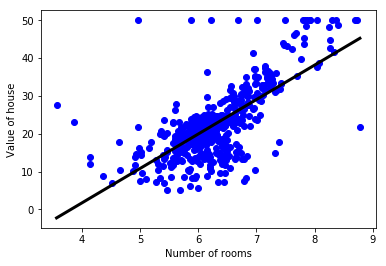

In [66]:
# Instantiate a linear regressor model
reg = LinearRegression()

# Fit the model to the data
reg.fit(X_rooms, y)

# Create the prediction space
prediction_space = np.linspace(min(X_rooms), 
                               max(X_rooms)).reshape(-1,1)

# Plot regression line against
plt.scatter(X_rooms, y, color='blue') 
plt.ylabel('Value of house')
plt.xlabel('Number of rooms')

# Plot a regression line against home price vs. number of rooms
plt.plot(prediction_space, reg.predict(prediction_space), color='black', linewidth=3)

# Display the new plot
plt.show()

#### Regression Line
Great! We can clearly see how a line of best fit correlates the numbers of rooms in a house with the price of a home. But how well does this model perform?  

In [73]:
# Print R^2 score
print(reg.score(X_rooms, y))

0.4835254559913343


#### R-squared
One way of measuring a linear model's performance is with R-squared, which is the proportion of the variance in the dependent variable that is predictable from the independent variable (between 0 and 1). Wow, okay, .483 is not a great R-squared score, however, we're only using one feature, and the score shows that nearly half variance is attributable to this one feature. Not bad! 


#### Training data and testing data
If we add back in the rest of the features we may be able to return a higher performing model. To do this, we'll also need to split the data up into a training set and test set. We want the model to perform well not only on seen data (training), but also on unseen data (test). That is to say, we want to train our data to perform well, and then test how well it performs on data it hasn't seen yet.

I'll try visualing the regression model next.

In [ ]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = lm.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

#### Visualizing the Model
The above snippet will fit a model based on X_train and Y_train. Now we already got the linear model, we try to predict it to the X_test and now we got the prediction values which stored into Y_pred. To visualize the differences between actual prices and predicted values we also create a scatter plot.

Ideally, the scatter plot should create a linear line. Since the model does not fit 100%, the scatter plot is not creating a linear line.

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

#### Mean Squared Error
To check the level of error of a model, we can Mean Squared Error. It is one of the procedure to measures the average of the squares of error. Basically, it will check the difference between actual value and the predicted value. For the full theory, you can always search it online. To use it, we can use the mean squared error function of scikit-learn by running this snippet of code.

In [68]:
df = pd.read_csv('datasets/boston.csv')

# Instantiate a ridge regressor
ridge = Ridge(alpha=0.5, normalize=True)

# Create arrays for features and target variable
y = df['MEDV'].values
X = df.drop('MEDV', axis=1).values

# Perform 5-fold cross-validation
ridge_cv = cross_val_score(ridge, X, y, cv=5)

# Print the cross-validated scores
print(ridge_cv)


[0.66758848 0.69340446 0.47352712 0.24855188 0.29564884]


In [61]:
# Import the neccessary modules
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate an ElasticNet regressor
elastic_net = ElasticNet(tol=1)

# Setup the GridSearchCV object
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_train, y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet l1 ratio: {'l1_ratio': 1.0}
Tuned ElasticNet R squared: 0.677335399361
Tuned ElasticNet MSE: 23.9435705932


In [62]:
# Import the neccessary modules
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Setup the pipeline steps and take the mean of a given feature/column in place of any missing values.
steps = [('imputation', Imputer(missing_values='NaN', strategy='mean', axis=0)),
         ('scaler', StandardScaler()),
         ('elasticnet', ElasticNet(tol=1))]

# Create the pipeline
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'elasticnet__l1_ratio':np.linspace(0,1,30)}

# Create the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(pipeline, parameters, cv=5)

# Fit to the training set
gm_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = gm_cv.score(X_test, y_test)
print("Tuned ElasticNet Alpha: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet Alpha: {'elasticnet__l1_ratio': 0.896551724137931}
Tuned ElasticNet R squared: 0.665852485814
Tuned ElasticNet MSE: 23.9435705932
